<a href="https://www.kaggle.com/code/tomkarlsson/playground-s04e03-001?scriptVersionId=165152903" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

# Playground Competition Season 04 Episode 03
My approach is to start of with the most basic model, named 'Vanilla', then try out various techniques to improve the accuracy of its final result. I am focusing on using Keras Squential model. A neural network. This might not be the best approach, but it is the model I want to increase my knowledge in. Over the course of this month I will get various scores from tweaking settings. These results are displayed in the table below.

| Model       | Focus area             | Submitted AUC score |
|-------------|------------------------|---------------------|
| Vanilla 0.1 | None                   | 0.54859             |
| Vanilla 0.2 | Standardize input data | 0.57534             |
| Vanilla 0.3 | Re-sampling data.      | 0.49236             |


In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/playground-series-s4e3/sample_submission.csv
/kaggle/input/playground-series-s4e3/train.csv
/kaggle/input/playground-series-s4e3/test.csv


In [2]:
train_data = pd.read_csv('/kaggle/input/playground-series-s4e3/train.csv', index_col='id')
test_data = pd.read_csv('/kaggle/input/playground-series-s4e3/test.csv', index_col='id')

In [3]:
# Display
print(f'train_data.shape: {train_data.shape:}, test_data.shape{test_data.shape}')
print(f'Number of dtypes: {pd.unique(train_data.dtypes)}')
print(f'Number of NA values: {train_data.isna().sum().sum()}')

train_data.shape: (19219, 34), test_data.shape(12814, 27)
Number of dtypes: [dtype('int64') dtype('float64')]
Number of NA values: 0


In [4]:
# Seperate X,y
prediction_categories = train_data.columns.drop(test_data.columns)
prediction_categories
X_full = train_data.drop(prediction_categories, axis=1)
y_full = train_data[prediction_categories].copy()
assert(X_full.shape[1] == test_data.shape[1])

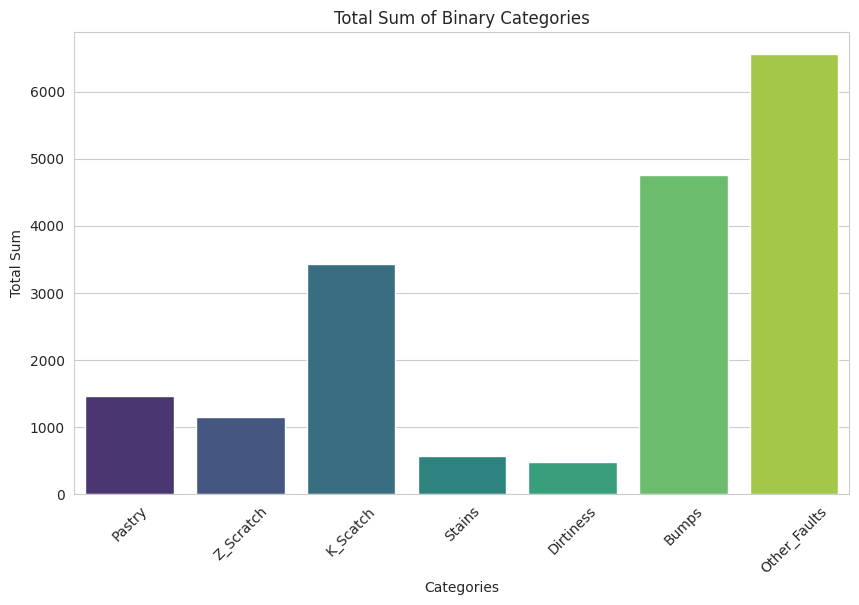

In [5]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Calculate the total sum for each category (column)
totals = np.array(y_full.sum())

# Get the column names (categories)
categories = np.array(y_full.columns)

# Create a bar plot using seaborn
sns.set_style("whitegrid")  # Set style
plt.figure(figsize=(10, 6))  # Set figure size

# Create the bar plot
sns.barplot(x=categories, y=totals, palette="viridis")

# Add labels and title
plt.xlabel("Categories")
plt.ylabel("Total Sum")
plt.title("Total Sum of Binary Categories")

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show plot
plt.show()

**Note:** We can see that our training data is unbalanced.

# Vanilla 0.1
I will start by creating a NN model using default values. It will provide the base result upon which we can try to improve later on. 

In [6]:
from sklearn.model_selection import train_test_split
# Break off validation set from training data
X_train, X_valid, y_train, y_valid = train_test_split(X_full, y_full, train_size=0.8, test_size=0.2)

In [7]:
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

num_classes = y_train.shape[1]
num_features = X_train.shape[1]

def get_model_vanilla(learning_rate=0.3) -> Sequential:
    # Create a Sequential model
    model = Sequential([
        Dense(num_features, activation='relu', input_shape=(num_features,)),
        Dense(64, activation='relu'),
        Dense(32, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])

    # Compile the model
    opt = tf.keras.optimizers.Adam(learning_rate=learning_rate)
    model.compile(optimizer=opt,
                  loss='categorical_crossentropy',  # Use categorical cross-entropy for multi-class classification
                  metrics=['accuracy','auc'])

    # Name the model
    model.name = 'Vanilla' 
    return model

model = get_model_vanilla()
# Print model summary
model.summary()

2024-03-02 16:16:47.829590: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-03-02 16:16:47.829732: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-03-02 16:16:48.006689: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "Vanilla"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ dense (Dense)                   │ (None, 27)             │           756 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 64)             │         1,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 32)             │         2,080 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 7)              │           231 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 4,859 (18.98 KB)

 Trainable params: 4,859 (18.98 KB)

 Non-trainable params: 0 (0.00 B)

In [8]:
from tensorflow.keras.callbacks import EarlyStopping

# Define early stopping callback
def get_early_stopping(patience=20,min_delta=0.001) -> EarlyStopping:
    return EarlyStopping(monitor='val_loss',
                         patience=patience, 
                         min_delta=min_delta,
                         restore_best_weights=True,
                         verbose=0,
                        )

early_stopping = get_early_stopping()
history = model.fit(
    X_train,y_train,
    validation_data=(X_valid,y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
)

Epoch 1/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 15ms/step - accuracy: 0.2075 - auc: 0.5825 - loss: 2295303.0000 - val_accuracy: 0.3418 - val_auc: 0.7583 - val_loss: 1.5514
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.2993 - auc: 0.7502 - loss: 1.5600 - val_accuracy: 0.3418 - val_auc: 0.7562 - val_loss: 1.5473
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3369 - auc: 0.7584 - loss: 1.5433 - val_accuracy: 0.3418 - val_auc: 0.7562 - val_loss: 1.5462
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3382 - auc: 0.7561 - loss: 1.5459 - val_accuracy: 0.3418 - val_auc: 0.7540 - val_loss: 1.5492
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.3407 - auc: 0.7590 - loss: 1.5463 - val_accuracy: 0.3418 - val_auc: 0.7562 - val_loss: 1.5474
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.3411 - auc: 0.7590 - loss: 1.5406 - val_accuracy: 0.3418 - val_auc: 0.7580 - val_loss: 1.5475
Epoch 7/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 

<Axes: title={'center': 'AUC'}>

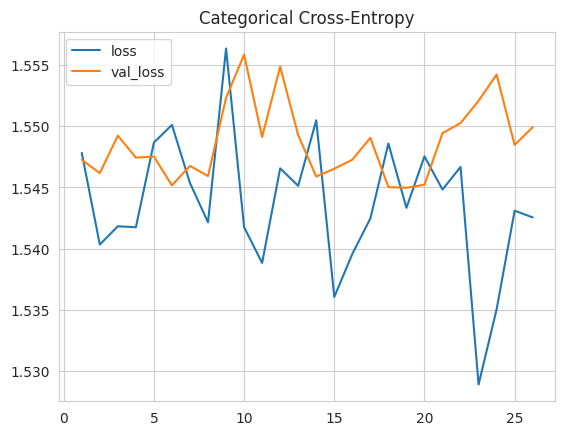

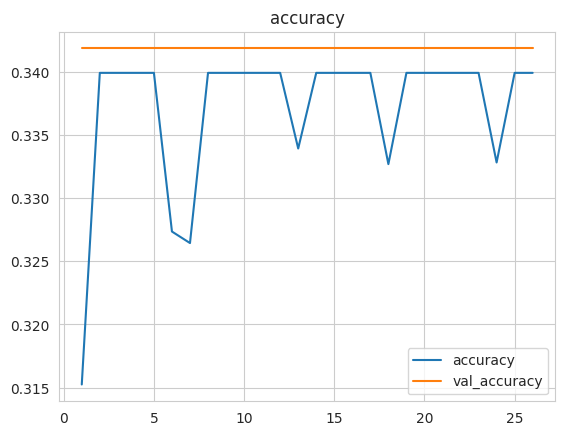

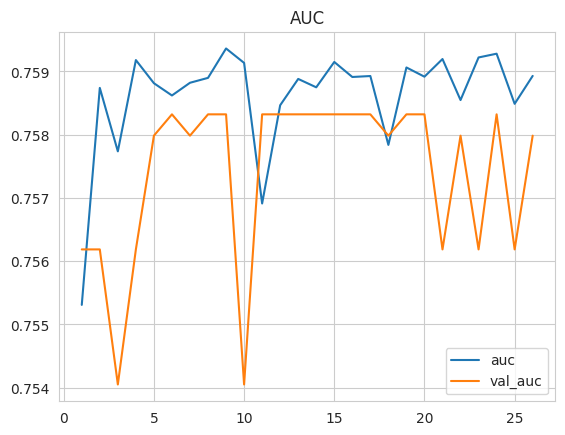

In [9]:
history_df = pd.DataFrame(history.history)
history_df.loc[1:, ['loss', 'val_loss']].plot(title="Categorical Cross-Entropy")
history_df.loc[1:, ['accuracy', 'val_accuracy']].plot(title="accuracy")
history_df.loc[1:, ['auc', 'val_auc']].plot(title="AUC")

In [10]:
def print_history(history) -> None:
    idx = np.argmin(history.history['val_loss'])
    print(f'Best validation accuracy: {history.history["val_accuracy"][idx]}')
    print(f'Best validation auc     : {history.history["auc"][idx]}')
    print(f'Best validation loss    : {history.history["val_loss"][idx]}')

print_history(history)

Best validation accuracy: 0.34183141589164734
Best validation auc     : 0.7590638399124146
Best validation loss    : 1.5449684858322144


## Conclusion vanilla 0.1
Our accuracy is quite low. There is definitely room for improvment. First off, our model is underfitting. Experimenting with Depth and Width of the neural network could help us pick up valuable patterns. There is also the issue that the input data isn't normalized, as well as the inbalance in the categorical outcomes. I will attack one of these issues at a time to see how it affects accuracy. Since normalizing inputs is almost always a good practice, that is what I will start with.

# Vanilla 0.2
I will continue to build upon the vanilla model and purely focus on the data of the inputs. First I will do an inspection on its values. Then do standardization, re-train the model and see if we get an improvement or not.

In [11]:
# Let us start by inspecting the input data
cols = X_train.columns
for i in range(0,len(cols),4):
    temp_cols = cols[i:i+4]
    print(X_train[temp_cols].describe(), '\n')

          X_Minimum     X_Maximum     Y_Minimum     Y_Maximum
count  15375.000000  15375.000000  1.537500e+04  1.537500e+04
mean     709.290862    753.556423  1.852574e+06  1.849238e+06
std      532.276997    500.273995  1.902439e+06  1.891340e+06
min        0.000000      4.000000  6.712000e+03  6.724000e+03
25%       48.000000    214.000000  6.594760e+05  6.612840e+05
50%      776.000000    796.000000  1.398904e+06  1.399304e+06
75%     1152.000000   1166.000000  2.366381e+06  2.364730e+06
max     1705.000000   1713.000000  1.298766e+07  1.298769e+07 

        Pixels_Areas   X_Perimeter   Y_Perimeter  Sum_of_Luminosity
count   15375.000000  15375.000000  15375.000000       1.537500e+04
mean     1703.645398     96.566439     64.678634       1.930468e+05
std      3817.448731    181.269452    102.141609       4.431542e+05
min         6.000000      2.000000      1.000000       2.550000e+02
25%        90.000000     15.000000     14.000000       9.948000e+03
50%       169.000000     25.0000

In [12]:
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer

# Pick columns with a 'large' mean, 
# I will chose 2.5 just to avoid manipulation the Log-based categories
cols_to_std = [c for c in cols if X_train[c].mean() > 2.5]

# Bundle preprocessing for numerical and categorical data
my_preprocessor = ColumnTransformer(
    transformers=[
        ('large mean', StandardScaler(), cols_to_std),
    ])
X_train[cols_to_std] = my_preprocessor.fit_transform(X_train)

In [13]:
X_train.describe()

,X_Minimum,X_Maximum,Y_Minimum,Y_Maximum,Pixels_Areas,X_Perimeter,Y_Perimeter,Sum_of_Luminosity,Minimum_of_Luminosity,Maximum_of_Luminosity,...,Outside_X_Index,Edges_X_Index,Edges_Y_Index,Outside_Global_Index,LogOfAreas,Log_X_Index,Log_Y_Index,Orientation_Index,Luminosity_Index,SigmoidOfAreas
count,1.537500e+04,1.537500e+04,1.537500e+04,1.537500e+04,1.537500e+04,1.537500e+04,1.537500e+04,1.537500e+04,1.537500e+04,1.537500e+04,...,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000,15375.000000
mean,-5.037344e-17,1.021333e-16,-6.331340e-17,-4.159275e-17,2.356922e-17,-2.957706e-17,-1.016712e-17,3.881990e-17,-2.315329e-16,5.469446e-16,...,0.030706,0.613052,0.831742,0.593626,2.477241,1.314776,1.392351,0.103159,-0.138628,0.574555
std,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,1.000033e+00,...,0.047261,0.222693,0.220640,0.481745,0.761636,0.468016,0.405497,0.487077,0.120540,0.332408
min,-1.332603e+00,-1.498341e+00,-9.702925e-01,-9.742166e-01,-4.447213e-01,-5.217068e-01,-6.234551e-01,-4.350586e-01,-2.933159e+00,-6.291147e+00,...,0.001500,0.014400,0.112300,0.000000,0.778200,0.301000,0.000000,-0.988400,-0.885000,0.119000
25%,-1.242421e+00,-1.078557e+00,-6.271618e-01,-6.281226e-01,-4.227163e-01,-4.499881e-01,-4.961767e-01,-4.131852e-01,-5.755136e-01,-3.231563e-01,...,0.006600,0.450000,0.655200,0.000000,1.954200,1.000000,1.079200,-0.272700,-0.192600,0.257000
50%,1.253319e-01,8.484342e-02,-2.384755e-01,-2.378997e-01,-4.020212e-01,-3.948198e-01,-3.982702e-01,-3.939519e-01,1.872541e-01,-1.125213e-01,...,0.009500,0.636400,0.963000,1.000000,2.227900,1.146100,1.322200,0.111100,-0.142700,0.472900
75%,8.317540e-01,8.244622e-01,2.700867e-01,2.725626e-01,-2.741830e-01,-1.741466e-01,-3.601621e-02,-2.822333e-01,7.073230e-01,4.491719e-01,...,0.019100,0.785000,1.000000,1.000000,2.816900,1.431400,1.716000,0.529400,-0.084200,0.999400
max,1.870721e+00,1.917899e+00,5.853249e+00,5.889379e+00,3.954376e+01,4.113587e+01,8.207709e+00,2.572183e+01,3.862407e+00,8.734147e+00,...,0.665100,1.000000,1.000000,1.000000,4.554300,2.997300,4.033300,0.991700,0.642100,1.000000


In [14]:
# Get a new model with slower learning rate
model = get_model_vanilla(learning_rate=0.005)
print(f'New model: {model.name}')

early_stopping = get_early_stopping()
history = model.fit(
    X_train,y_train,
    validation_data=(X_valid,y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
    verbose=0
)

/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


New model: Vanilla


In [15]:
# Lets inspect our results
print_history(history)

Best validation accuracy: 0.17221644520759583
Best validation auc     : 0.6326168179512024
Best validation loss    : 72694.609375


### Conclusion vanilla 0.2, standardized input data
Well, we did see improvements. Our submitted score went up by a small fraction. I still believe this is a good approach to take. When we move on to make the model more complex this could have even more impact. Note: There is also the possibility to 'bake in' the standardization/normalization as a layer in the NN of the model. This might be something to explore later on.

# Vanilla 0.3, tackle the inbalance
So there are a few different options such as adding (initial) weights and re-sampling. I will do a combinaiton of over-sampling and under-sampling. This will be done in a naive way using randomness do dublicate and remove data.

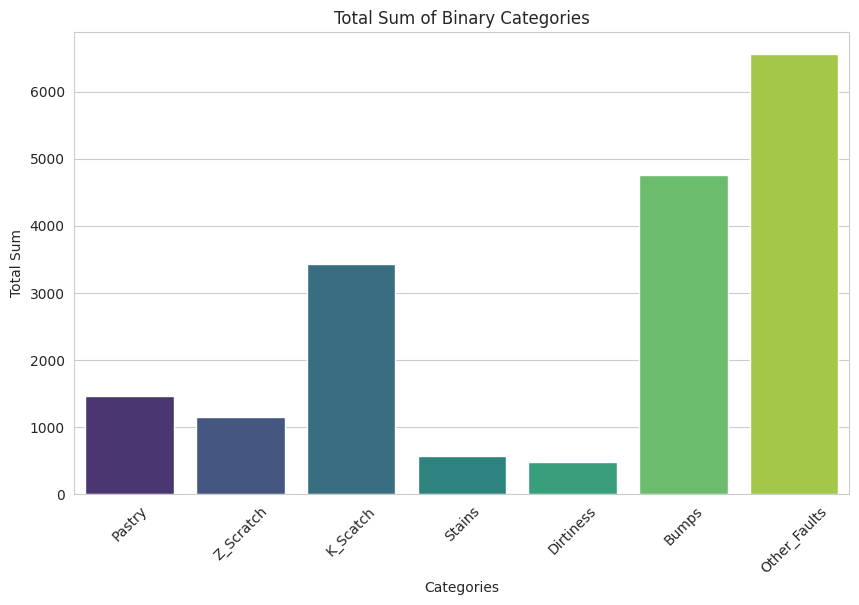

In [16]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Calculate the total sum for each category (column)
totals = np.array(y_full.sum())

# Get the column names (categories)
categories = np.array(y_full.columns)

# Create a bar plot using seaborn
sns.set_style("whitegrid")  # Set style
plt.figure(figsize=(10, 6))  # Set figure size

# Create the bar plot
sns.barplot(x=categories, y=totals, palette="viridis")

# Add labels and title
plt.xlabel("Categories")
plt.ylabel("Total Sum")
plt.title("Total Sum of Binary Categories")

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show plot
plt.show()

In [17]:
labels = y_train.columns
n_labels = len(labels)
total = y_train.shape[0]
print(f"We have {n_labels} classification labels and a total of {total} training examples. Their ratio is as follows:")
for label in labels:
    ratio = y_train[label].sum() / total
    print(f"{label} : \t{ratio}")

We have 7 classification labels and a total of 15375 training examples. Their ratio is as follows:
Pastry : 	0.0751869918699187
Z_Scratch : 	0.0608130081300813
K_Scatch : 	0.18016260162601627
Stains : 	0.02913821138211382
Dirtiness : 	0.024715447154471545
Bumps : 	0.248
Other_Faults : 	0.34087804878048783


In [18]:
X_train_resample = X_train.copy()
y_train_resample = y_train.copy()

# Identify indices of samples where y_train is True
true_indices = y_train_resample[y_train_resample['Other_Faults'] == True].index
# Randomly select 100 indices from the true indices
indices_to_remove = np.random.choice(true_indices,size=2000,replace=False)

# Drop the selected indices from both X_train and y_train
X_train_resample = X_train_resample.drop(indices_to_remove)
y_train_resample = y_train_resample.drop(indices_to_remove)

# Identify indices of samples where y_train is True
true_indices = y_train_resample[y_train_resample['Bumps'] == True].index
# Randomly select 100 indices from the true indices
indices_to_remove = np.random.choice(true_indices,size=1000,replace=False)

# Drop the selected indices from both X_train and y_train
X_train_resample = X_train_resample.drop(indices_to_remove)
y_train_resample = y_train_resample.drop(indices_to_remove)

In [19]:
# Check ratio again
for label in labels:
    ratio = y_train_resample[label].sum() / total
    print(f"{label} : \t{ratio}")

Pastry : 	0.0751869918699187
Z_Scratch : 	0.0608130081300813
K_Scatch : 	0.17977235772357725
Stains : 	0.02913821138211382
Dirtiness : 	0.024715447154471545
Bumps : 	0.18295934959349594
Other_Faults : 	0.2107967479674797


In [20]:
# over sample the low-ratio labels
def oversample(X_train_resample,y_train_resample):
    for label in ['Pastry','Z_Scratch','Stains','Dirtiness']:
        # Identify indices of samples where y_train is True
        true_indices = y_train_resample[y_train_resample[label] == True].index

        # Randomly select 100 indices from the true indices
        indices_to_duplicate = np.random.choice(true_indices, size=100, replace=True)

        # Get the data corresponding to the selected indices
        data_to_duplicate_X = X_train_resample.loc[indices_to_duplicate]
        data_to_duplicate_y = y_train_resample.loc[indices_to_duplicate]

        # Append duplicated data to X_train and y_train
        X_train_resample = pd.concat([X_train_resample, data_to_duplicate_X])
        y_train_resample = pd.concat([y_train_resample, data_to_duplicate_y])
        
        # Shuffle the order
        shuffled_indices = np.random.permutation(len(X_train_resample))
        X_train_resample = X_train_resample.iloc[shuffled_indices]
        y_train_resample = y_train_resample.iloc[shuffled_indices]
        
    return X_train_resample,y_train_resample

X_r = X_train_resample.copy()
y_r = y_train_resample.copy()
for i in range(4): # test value to give decent ratio
    X_r,y_r = oversample(X_r,y_r)

for label in labels:
    ratio = y_r[label].sum() / total
    print(f"{label} : \t{ratio}")

Pastry : 	0.10952845528455285
Z_Scratch : 	0.1006829268292683
K_Scatch : 	0.17983739837398374
Stains : 	0.10744715447154471
Dirtiness : 	0.0913170731707317
Bumps : 	0.18295934959349594
Other_Faults : 	0.2107967479674797


In [21]:
# Save to global scope
X_train_resample = X_r
y_train_resample = y_r

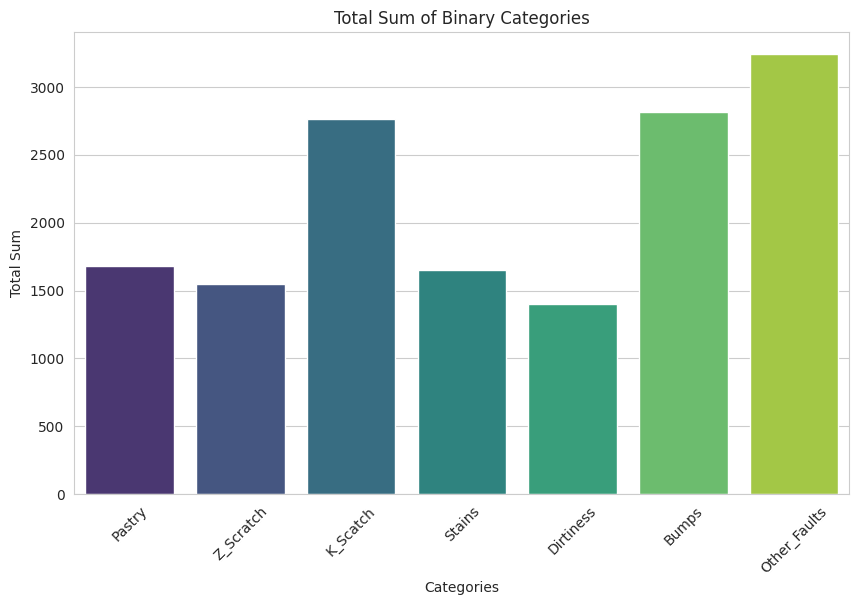

In [22]:
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns

# Calculate the total sum for each category (column)
totals = np.array(y_r.sum())

# Get the column names (categories)
categories = np.array(y_r.columns)

# Create a bar plot using seaborn
sns.set_style("whitegrid")  # Set style
plt.figure(figsize=(10, 6))  # Set figure size

# Create the bar plot
sns.barplot(x=categories, y=totals, palette="viridis")

# Add labels and title
plt.xlabel("Categories")
plt.ylabel("Total Sum")
plt.title("Total Sum of Binary Categories")

# Rotate x-axis labels for better readability if needed
plt.xticks(rotation=45)

# Show plot
plt.show()

After some manual over- and under-sampling we have evened out the inbalance in the data. I did not go to ham because there might be value in keeping a fraction of the inbalance if it will be reflected on the test data. Let us see how our vanilla model perform on this training data.

In [23]:
# Get a new model with slower learning rate
model = get_model_vanilla(learning_rate=0.005)
print(f'New model: {model.name}')

early_stopping = get_early_stopping()
history = model.fit(
    X_train_resample,y_train_resample,
    validation_data=(X_valid,y_valid),
    batch_size=512,
    epochs=200,
    callbacks=[early_stopping],
    verbose=1
)

New model: Vanilla
Epoch 1/200


/opt/conda/lib/python3.10/site-packages/keras/src/layers/core/dense.py:85: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


31/31 ━━━━━━━━━━━━━━━━━━━━ 2s 14ms/step - accuracy: 0.3611 - auc: 0.7611 - loss: 1.5101 - val_accuracy: 0.0578 - val_auc: 0.4522 - val_loss: 191449.0781
Epoch 2/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5600 - auc: 0.9023 - loss: 1.0072 - val_accuracy: 0.0575 - val_auc: 0.4521 - val_loss: 265875.5625
Epoch 3/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.5635 - auc: 0.9031 - loss: 1.0124 - val_accuracy: 0.1397 - val_auc: 0.5018 - val_loss: 241413.2188
Epoch 4/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - accuracy: 0.4310 - auc: 0.8098 - loss: 1.9412 - val_accuracy: 0.1316 - val_auc: 0.4969 - val_loss: 380904.1250
Epoch 5/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step - accuracy: 0.3986 - auc: 0.7239 - loss: 4.7881 - val_accuracy: 0.0554 - val_auc: 0.4507 - val_loss: 179709.6875
Epoch 6/200
31/31 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - accuracy: 0.2961 - auc: 0.6045 - loss: 14.4604 - val_accuracy: 0.1467 - val_auc: 0.5061 - val_loss: 183896.8750
Epoch 7/200
31/31 ━━━━━━━━

In [24]:
# Lets inspect our results
print_history(history)

Best validation accuracy: 0.17403745651245117
Best validation auc     : 0.5612941384315491
Best validation loss    : 249.41802978515625


### Conclusion
Some minor improvements in testing, although not as much as I had hoped. The final test score was acutally a lot less. I guess tampering with the sampling rate is not a good decision for this competition outcome. This will finish my vanilla model. Next up will be to start enhancing the model and leave the data as is.

In [25]:
# Train and submit
X_test = test_data
X_test[cols_to_std] = my_preprocessor.transform(test_data)
y_hat = model.predict(X_test)

401/401 ━━━━━━━━━━━━━━━━━━━━ 1s 1ms/step


In [26]:
output = pd.DataFrame(y_hat, columns=y_train.columns, index=test_data.index)
print(output.head())
output.to_csv('submission_vanilla_001.csv', index=True)

       Pastry  Z_Scratch  K_Scatch  Stains  Dirtiness  Bumps  Other_Faults
id                                                                        
19219     1.0        0.0       0.0     0.0        0.0    0.0           0.0
19220     1.0        0.0       0.0     0.0        0.0    0.0           0.0
19221     1.0        0.0       0.0     0.0        0.0    0.0           0.0
19222     1.0        0.0       0.0     0.0        0.0    0.0           0.0
19223     1.0        0.0       0.0     0.0        0.0    0.0           0.0
